**Brain MRI Images for Brain Tumor Detection**

In [ ]:
!pip install tensorflow opencv-python-headless numpy scikit-learn matplotlib seaborn

# 1. Importing Necessary Libraries

In [ ]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import confusion_matrix, classification_report

**Explanation**: In this cell, we import all the necessary libraries.

-`cv2` for image manipulation (reading, resizing, etc.),

-`numpy` for numerical operations,

-`matplotlib` for visualizing images and results,

-`sklearn.model_selection.train_test_split` for splitting the dataset into training and testing sets,

-`tensorflow.keras` for building the CNN model and training,

-`ImageDataGenerator` for real-time data augmentation (optional).

# 2. Loading and Preprocessing the Data

In [ ]:
def load_images_from_folder(folder, label, img_size=(128, 128)):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, img_size)
            img = img / 255.0
            images.append(img)
            labels.append(label)
    return np.array(images), np.array(labels)

images_no, labels_no = load_images_from_folder('no', label=0) #no fold path
images_yes, labels_yes = load_images_from_folder('yes', label=1) #yes fold path

X = np.concatenate((images_no, images_yes), axis=0)
y = np.concatenate((labels_no, labels_yes), axis=0)

**Explanation**: This cell defines the function `load_images_from_folder` that:

-Reads images from a specified folder,

-Converts them into grayscale (necessary for CNN input),

-Resizes all images to the same size (`128x128`),

-Normalizes pixel values (scaling between 0 and 1). We load images from two folders: one containing images labeled with `0` (no tumor) and the other with `1` (tumor). Then we combine both image arrays into one (`X`) and the labels into one (`y`).

# 3. Splitting the Data into Training and Testing Sets

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X_train.reshape(-1, 128, 128, 1)
X_test = X_test.reshape(-1, 128, 128, 1)

**Explanation**: In this cell:

-We use `train_test_split` to split the data into training and testing sets. 80% of the data is used for training, and 20% is used for testing.

-We then reshape the data to match the input format for the CNN model, which expects images with the shape (`height, width, channels`). Since the images are grayscale, the number of channels is 1.

# 4. Building the CNN Model

In [ ]:
model = Sequential([
    Input(shape=(128, 128, 1)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

**Explanation**: In this cell, we build the CNN model using `Sequential()`:

-The first layer is an `Input` layer that defines the input shape.

-We add three `Conv2D` layers with `ReLU` activation, which will learn features from the images.

-After each convolutional layer, we add a `MaxPooling2D` layer to reduce the image dimensions.

-After the convolutional layers, we flatten the data and add a fully connected `Dense` layer to make predictions.

-The output layer uses a `sigmoid` activation to output a value between 0 and 1, indicating the presence or absence of a tumor.

-We compile the model with the `Adam` optimizer and binary crossentropy loss function (since this is a binary classification task).

# 5. Training the Model

In [ ]:
history = model.fit(X_train, y_train, epochs=15, batch_size=16, validation_data=(X_test, y_test))

**Explanation**: In this cell, we train the model using the training data (`X_train` and `y_train`).

-We use `epochs=10` to train the model for 10 iterations over the entire dataset. You can increase this number to train for more epochs.

-We also specify a `batch_size` of 16, meaning that the model will process 16 images at a time.

-`validation_data=(X_test, y_test)` ensures that the model is validated on the test set after each epoch.

# 6. Visualizing Model Performance

In [ ]:
plt.figure(figsize=(12, 4))

# acc plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

**Explanation**: This cell visualizes the model’s performance by plotting:

-The training and validation accuracy over the epochs.

-The training and validation loss over the epochs. This helps in understanding if the model is overfitting or underfitting.

NOTE: Due to our small dataset, the model may tend to overfit. To prevent this, you can add more data, add a dropout layer, or add regularization techniques such as L2 or L1.

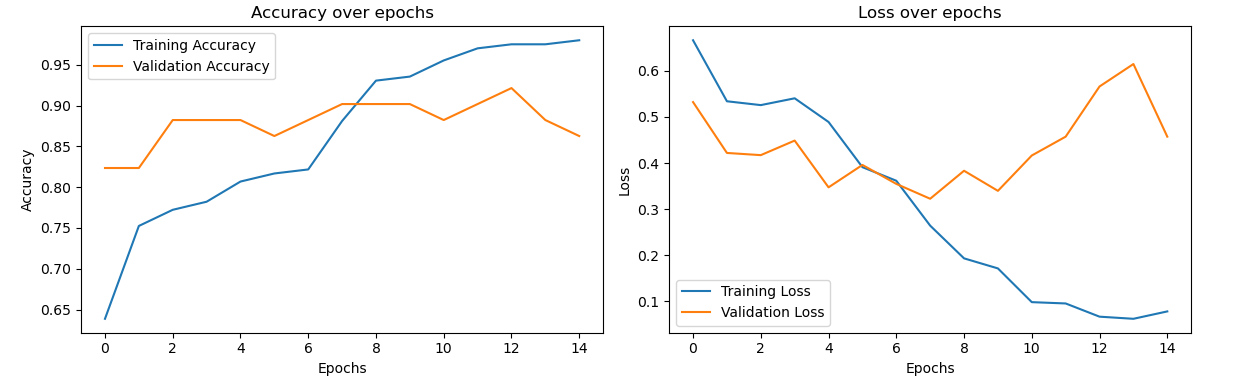

# 7. Confusion Matrix and Classification Report

In [ ]:
y_pred = model.predict(X_test)
y_pred = np.round(y_pred).astype(int)

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

**Explanation**:

-We first predict on the test set (`X_test`) and round the predictions to `0` (no tumor) or `1` (tumor).

-The `confusion_matrix` function from `sklearn.metrics` gives us a matrix that shows how many predictions are true positives (tumor correctly predicted), false positives (no tumor predicted as tumor), true negatives (no tumor correctly predicted), and false negatives (tumor predicted as no tumor).

-The `classification_report` provides a detailed performance analysis, including precision, recall, F1 score, and support for each class.

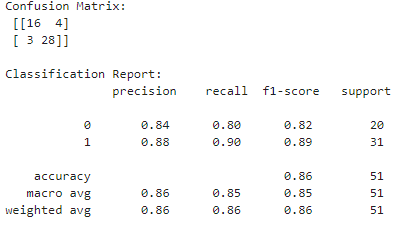

-**Precision** tells you the percentage of correct positive predictions among all positive predictions.

-**Recall** tells you the percentage of actual positive cases that were correctly identified.

-**F1-score** is the harmonic mean of precision and recall, providing a single score to evaluate the model's performance.

# 8. Visualizing Tumor Detection Results

In [ ]:
y_pred = model.predict(X_test)
y_pred = np.round(y_pred).astype(int)

def plot_images_with_boxes(X_test, y_test, y_pred, num_images=5, img_size=(128, 128)):
    plt.figure(figsize=(12, 12))
    idx = 0
    for i in range(num_images):
        img = X_test[i].reshape(img_size)
        img = img * 255
        img = img.astype(np.uint8)

        plt.subplot(1, num_images, idx + 1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')

        if y_pred[i] == 1:
            plt.title("Tumor Detected", color='red')
            h, w = img.shape
            cv2.rectangle(img, (int(w * 0.3), int(h * 0.3)), (int(w * 0.7), int(h * 0.7)), (255, 0, 0), 3)  # Kırmızı kutu
        else:
            plt.title("No Tumor", color='green')

        plt.imshow(img, cmap='gray')
        idx += 1
    plt.show()

plot_images_with_boxes(X_test, y_test, y_pred, num_images=5)

**Explanation**: This cell visualizes the model's predictions:

-We display a few images from the test set and, for each image, draw a red rectangle around the area where the model detects a tumor (if the prediction is `1`).

-The title of the image indicates whether a tumor was detected or not.
This helps in visually verifying the model's accuracy and areas of focus.

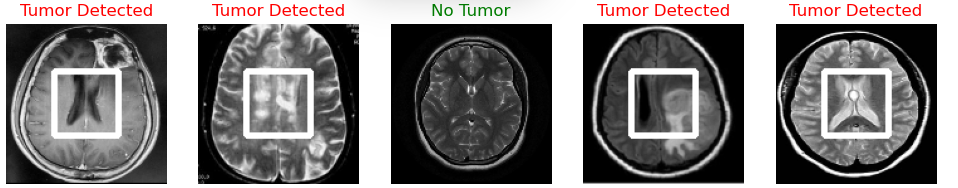